<a href="https://colab.research.google.com/github/nbchan/INMR96-Digital-Health-and-Data-Analytics/blob/main/Week_11_Explainable_AI_showcase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIMIC-III Example: In-hospital Mortality Prediction (Cont'd)

# 1. Setting up

**Packages for data handling and visualization**

In [ ]:
import pandas as pd
import numpy as np

import graphviz
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme()

**Packages for data analysis and modelling**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay

**Packages for Explainability**

We will be using the package [shap](https://shap-lrjball.readthedocs.io/en/latest/index.html) but it is not installed in Colab by default. Let's install it before importing it. Don't worry too much about the installation messages unless an error pops up. 

In [ ]:
!pip install shap
import shap

**Import the intermediate dataset and Authenication for Google Drive access**

If you saved the intermediate dataset in your Google Drive by following all the steps in the previous tutorial, you can grant Colab access to your Google Drive and import the intermediate dataset to the current notebook.

Alternatively, when you are working on your own analysis, you may also put everything (e.g. codes for extracting data from BigQuery; exploring data; preparing and cleaning data; building models) in a single notebook. In that case, you do not need to import the dataset from your Google Drive - simply continue with the cleaned dataset in your existing notebook environment. 


In [ ]:
import joblib
from google.colab import drive 
drive.mount('/content/gdrive', force_remount = True) # you would need to authenicate yourself here

gdrive_rootpath = '/content/gdrive/MyDrive/' 
# if you saved the file inside a folder in your Google Drive (instead of the base path), 
# you would need to append the folder name to the above

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 64 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SUBJECT_ID                        58976 non-null  int64  
 1   HADM_ID                           58976 non-null  int64  
 2   ADMISSION_TYPE                    58976 non-null  object 
 3   ADMITTIME                         58976 non-null  object 
 4   DISCHTIME                         58976 non-null  object 
 5   DEATHTIME                         5854 non-null   object 
 6   DIAGNOSIS                         58951 non-null  object 
 7   MARITAL_STATUS                    58976 non-null  object 
 8   INSURANCE                         58976 non-null  object 
 9   LANGUAGE                          58976 non-null  object 
 10  RELIGION                          58976 non-null  object 
 11  ETHNICITY                         58976 non-null  object 
 12  GEND

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,...,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaN,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,...,0,1,1,0,0,0,1,0,0,0
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaN,MVA;TRAUMA,SINGLE,Government,ENGL,...,0,0,1,0,0,0,0,1,0,0
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaN,INFECTED RIGHT FOOT,DIVORCED,Medicare,ENGL,...,0,1,1,0,0,0,1,0,0,0
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaN,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,...,0,0,1,0,0,0,1,0,0,0
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaN,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,...,0,1,1,0,0,0,1,0,0,0


---

# 2. Train-test Split

We will split the dataset into a training set and a test set with the same codes included in the previous tutorial. 

`IN_HOSP_DEATH` would be our prediction target. Here, let's define a list of 38 column names for features/inputs we would use in the model as not all columns are appropriate (e.g. `SUBJECT_ID`). 

In [ ]:
features_list = ['GENDER_F', 'AGE', 'LOS', 'LOS_ICU', 
                 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY', 'PROC_COUNT_DAY',
                 'CPT_COUNT_DAY', 'LAB_COUNT_DAY', 'INPUTS_CV_COUNT_DAY',
                 'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
                 'MICRO_COUNT_DAY', 
                 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN', 'ADMISSION_TYPE_URGENT', 
                 'RELIGION_CATHOLIC', 'RELIGION_NOT SPECIFIED', 'RELIGION_UNOBTAINABLE', 'RELIGION_OTHERS', 
                 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Medicaid', 'INSURANCE_OTHERS',
                 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_OTHERS',
                 'LANGUAGE_ENGL', 'LANGUAGE_SPAN', 'LANGUAGE_RUSS', 'LANGUAGE_OTHERS',
                 'ETHNICITY_WHITE', 'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_OTHERS']

len(features_list)

38

 Then, create a DataFrame containing input features only as well as a Series containing our prediction target. 

In [ ]:
X = df[features_list]
y = df['IN_HOSP_DEATH']

Finally, use `train_test_split()` from the package [Scikit-learn](https://scikit-learn.org/stable/) to perform a train-test split. 

Note that the function outputs four things: the input and output datasets for training and testing respectively. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,  # 20% of data belongs to the test set
                                                    random_state = 1, # make sure the split is the same across different devices for illustrative purposes
                                                    stratify = y)     # ensure the number of positive examples in the train and test sets are similar

In [ ]:
X_train.shape

(47180, 38)

In [ ]:
X_test.shape

(11796, 38)

As a result, our training and test set would include 47,180 and 11,796 admissions respectively. 

---

# 3. Instrinsically Interpretable Models:  Logistic Regression Model

## 3.1. Model Training

In [ ]:
# 1. Specify a model to be trained
model_lr = LogisticRegression(random_state = 1, 
                              n_jobs = -1) # use all available CPUs within your Colab notebook for computation

In [ ]:
# 2. Train the model
model_lr.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=1)

In [ ]:
# 3. Make predictions
y_pred_lr = model_lr.predict(X_test)
y_pred_lr

array([1, 0, 0, ..., 0, 0, 0])

Use `.predict_proba()` instead if you want probabilistic outputs over class outputs. 

In [ ]:
y_pred_prob_lr = model_lr.predict_proba(X_test) 
y_pred_prob_lr # the two columns represent the prob of class 0 and 1 respectively 

array([[0.31669348, 0.68330652],
       [0.99281121, 0.00718879],
       [0.93265852, 0.06734148],
       ...,
       [0.81834718, 0.18165282],
       [0.98375212, 0.01624788],
       [0.94483697, 0.05516303]])

## 3.2. Interpretation

Trained Weights of the features is stored in `.coef_`. Let's extract it and have a look. 

In [ ]:
pd.DataFrame({'Coefficient': model_lr.coef_[0], 'Factor': np.exp(model_lr.coef_[0])}, features_list)\
  .sort_values(by='Coefficient', ascending=False)

,Coefficient,Factor
PROC_COUNT_DAY,0.555739,1.743229
CPT_COUNT_DAY,0.379206,1.461124
MICRO_COUNT_DAY,0.111582,1.118045
LAB_COUNT_DAY,0.034086,1.034674
INPUTS_MV_COUNT_DAY,0.021700,1.021937
PRES_COUNT_DAY,0.009621,1.009668
INPUTS_CV_COUNT_DAY,0.009391,1.009436
LOS,0.001690,1.001691
AGE,0.000297,1.000297
LOS_ICU,-0.010449,0.989606


**Interpretation**

* **Numerical features**: If you increase the value of feature by one unit, the estimated odds change by that given factor. For example, if `PROC_COUNT_DAY` increases by 1, the predicted probability shoots up by 74.3% from the original amount (multiplicatively, not additively).
* **Binary categorical feature**: One of the two values of the feature is the reference category (in most cases, the one encoded in 0). Changing the feature  from the reference category to the other category changes the estimated odds by that given factor. For example, if `LANGUAGE_ENGL` is 1 (i.e. the primary language of the patient is English amongst all others), then the predicted probability drops by 65.9% (1 - 34.1%) from the original amount.

---

# 4. Using SHAP on a Random Forest Model

SHAP (SHapley Additive exPlanations) is a model-agnostic method which can be applied regardless of the underlying type of model. We can use SHAP to explain a model both locally and globally. SHAP can be thought of as a measure of impact of a feature value of a specific sample on its prediction. 

---

## 4.1. Model Training

In [ ]:
%%time
# 1. Specify
model_rf = RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=300,
                                   n_jobs=-1, random_state=1)
# 2. Train
model_rf.fit(X_train, y_train)

CPU times: user 28.8 s, sys: 148 ms, total: 28.9 s
Wall time: 17.6 s


In [ ]:
# 3. Predict
y_pred_prob_rf = model_rf.predict_proba(X)
y_pred_prob_rf

array([[0.82973466, 0.17026534],
       [0.78386905, 0.21613095],
       [0.61805874, 0.38194126],
       ...,
       [0.86136159, 0.13863841],
       [0.88088682, 0.11911318],
       [0.73822502, 0.26177498]])

---

## 4.2. Training a SHAP Explainer and Extracting SHAP values

To train a SHAP explainer based on the random forest model we have trained, we call the function `shap.TreeExplainer()` provided by the `shap` package. After that, we use `.shap_values()` to provide it with the *dataset we are interested in explaining*. Note that this does not necessarily have to be the training test (`X_train`) or the test data (`X_test`). In the following example, I extracted the SHAP values of the entire dataset (`X`). 

Another thing to note is that, the function `shap.TreeExplainer()` is only applicable to tree-based machine learning algorithms such as random forest. For a more general use case, we can use `shap.Explainer()` ([docs](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.Explainer.html)). 

In [ ]:
%%time
# Note: this may take around 1hr to run.
# 1. Specify
rf_explainer = shap.TreeExplainer(model_rf)
# 2. Train and Extract
rf_shap_values = rf_explainer.shap_values(X)

CPU times: user 1h 4min 14s, sys: 16.6 s, total: 1h 4min 30s
Wall time: 1h 4min 19s


**[Optional]** As the code above takes quite some time to run, we can export the results to our Google drive so that we can directly import the objects instead of needing to re-train it next time.

To save:

In [ ]:
joblib.dump(rf_explainer, gdrive_rootpath + 'rf_explainer.joblib')
joblib.dump(rf_shap_values, gdrive_rootpath + 'rf_shap_values.joblib')

['/content/gdrive/MyDrive/rf_shap_values.joblib']

To load:

In [ ]:
rf_explainer = joblib.load(gdrive_rootpath + 'rf_explainer.joblib')
rf_shap_values = joblib.load(gdrive_rootpath + 'rf_shap_values.joblib') 

In [ ]:
rf_shap_values

[array([[ 5.07624204e-04,  2.88733600e-02,  2.87703761e-02, ...,
         -2.57090838e-04,  2.41709771e-04,  3.38950925e-05],
        [ 1.45867717e-03,  1.10973015e-01,  1.92135802e-02, ...,
          6.84727830e-03,  1.20586332e-03, -4.39998564e-05],
        [ 1.11403398e-03,  1.21354649e-02,  2.71551795e-02, ...,
         -4.85713830e-04,  6.40758885e-04, -5.12904625e-05],
        ...,
        [-4.02637854e-04,  1.25280430e-01, -2.81105435e-02, ...,
         -6.37039165e-04,  5.04591044e-04,  1.22526601e-04],
        [ 1.02860501e-03,  4.27410785e-02,  2.42123807e-02, ...,
         -4.10235250e-04, -3.86845286e-03, -2.27562847e-05],
        [ 2.15380373e-03,  1.17835248e-01,  1.51515740e-02, ...,
         -3.28829059e-04,  6.10403717e-04, -9.49947782e-05]]),
 array([[-5.07624204e-04, -2.88733600e-02, -2.87703761e-02, ...,
          2.57090838e-04, -2.41709771e-04, -3.38950925e-05],
        [-1.45867717e-03, -1.10973015e-01, -1.92135802e-02, ...,
         -6.84727830e-03, -1.20586332e

In [ ]:
rf_shap_values[1].shape

(58976, 38)

In [ ]:
X.shape

(58976, 38)

* We can have a closer look of the extracted SHAP values (`rf_shap_values`). It is structured as a list of two arrays: one stores the SHAP values of the negative class (`rf_shap_values[0]`) and the other stores the SHAP values of the positive class (`rf_shap_values[1]`). The number of rows and columns of the two arrays is equal to the size of the input dataset (`X.shape`)
* For binary classification, `rf_shap_values[0]` is just the opposite of `rf_shap_values[1]` so we will only be focusing on `rf_shap_values[1]`. 

---

## 4.3. Feature Importance

Recall that one major strength of tree-based machine learning models is its inherent ability to easily report feature importance:

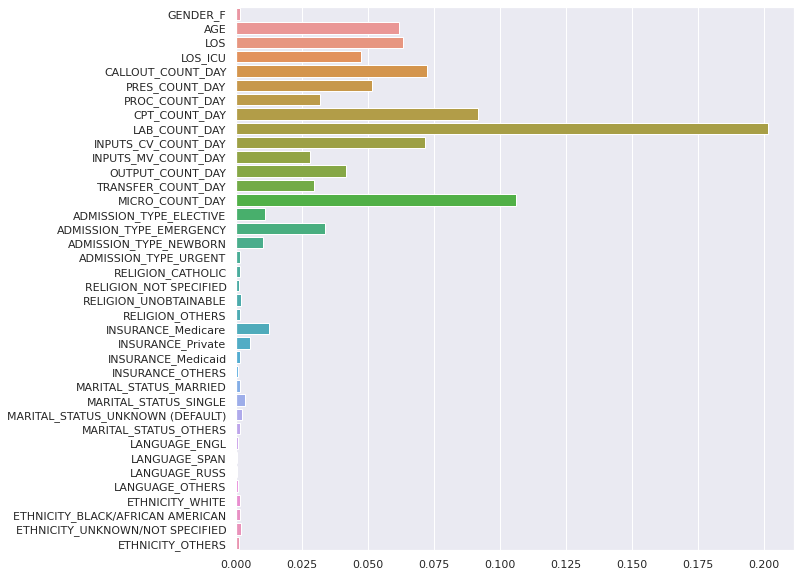

In [ ]:
model_rf_importance = pd.Series(model_rf.feature_importances_, index = features_list)
model_rf_importance

plt.figure(figsize = (10, 10))
sns.barplot(x = model_rf.feature_importances_, y = features_list)

Feature importance can be defined in different ways. Rather than using a typical feature importance bar chart directly from the `RandomForestClassifier()`, we use the SHAP values for each feature to identify how much impact each feature has on the model output for individuals. Features are sorted by the sum of the SHAP value magnitudes across all samples.

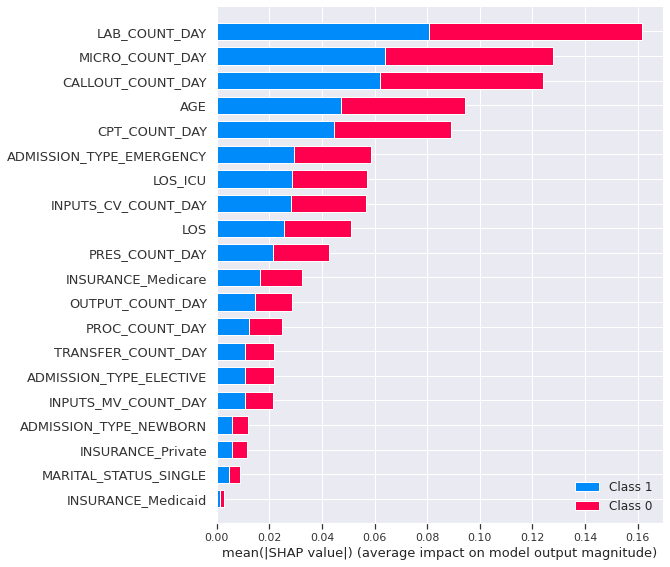

In [ ]:
shap.summary_plot(rf_shap_values, X_test)

---

## 4.4. SHAP dependence plots for Global Interpretability

Like partial dependence plots, SHAP dependence plots (`shap.dependence_plot()`) show the effect of a single feature across the whole dataset. They plot a feature’s value against the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features. 

When evaluating these figures, start by observing the shape and position of the dots. This tells you how different values of the feature leads to an increase or decrease in the model output probability. Then, observe the colour of the dots and compare them vertically. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is automatically chosen to highlight possible interactions.

Let's look at the dependence plots for the most important features we have found. 

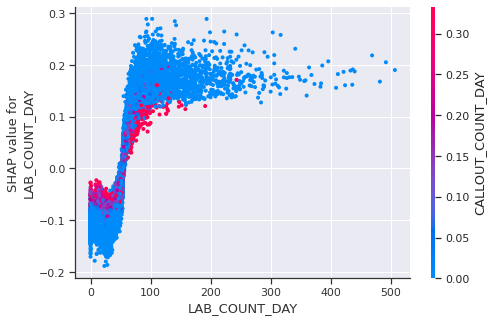

In [ ]:
shap.dependence_plot('LAB_COUNT_DAY', rf_shap_values[1], X)

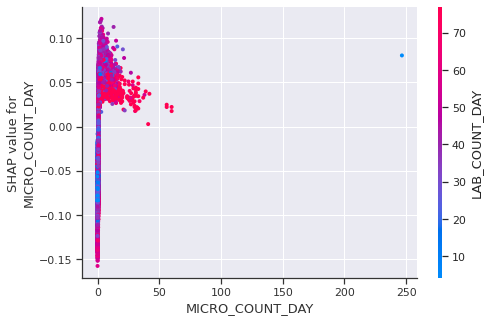

In [ ]:
shap.dependence_plot('MICRO_COUNT_DAY', rf_shap_values[1], X)

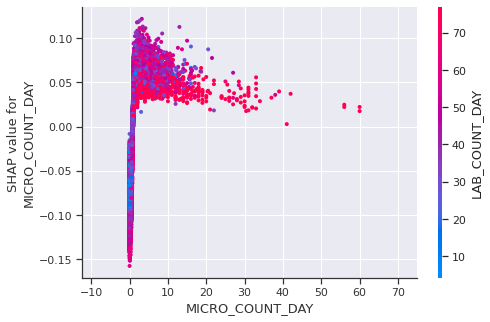

In [ ]:
# we can fine-tune the graph by omitting the outlier and zooming in. 
shap.dependence_plot('MICRO_COUNT_DAY', rf_shap_values[1], X, show = False)
plt.xlim(xmax = 75)
plt.show()

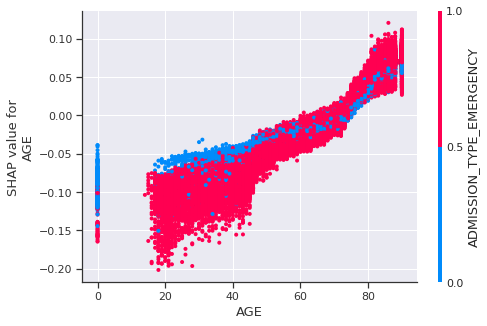

In [ ]:
shap.dependence_plot('AGE', rf_shap_values[1], X)

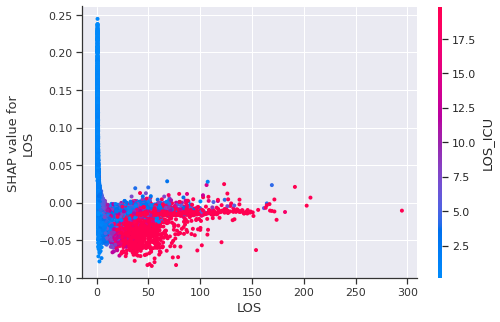

In [ ]:
shap.dependence_plot('LOS', rf_shap_values[1], X)

---

## 4.5. Individual SHAP value plot for Local Interpretability

Instead of visualising SHAP scores across the entire population, we can visualise SHAP scores specific to one prediction or one individual only. This is where the function `shap.force_plot()` comes in handy. Here is an exmaple to explain the prediction for the 5th row within the dataset. 

In [ ]:
shap.initjs()
shap.force_plot(rf_explainer.expected_value[1], rf_shap_values[1][4,:], X.iloc[4, :])

We can compliment this with a table that compares the features of this patient with all other patients: 

In [ ]:
# extract feature value and percentile for that patient. compare it with the mean of all patients
pd.DataFrame({'Mean': X.mean(axis=0).map('{:.2f}'.format), 
              'Value': X.iloc[4,:].map('{:.2f}'.format), 
              'Percentile': X.rank(pct=True, axis=0).iloc[4,:].map('{:.0%}'.format)})

,Mean,Value,Percentile
GENDER_F,0.44,0.00,28%
AGE,54.68,76.00,76%
LOS,10.15,5.59,43%
LOS_ICU,5.13,5.59,79%
CALLOUT_COUNT_DAY,0.09,0.00,26%
PRES_COUNT_DAY,8.11,8.83,59%
PROC_COUNT_DAY,0.54,1.00,88%
CPT_COUNT_DAY,0.92,1.67,83%
LAB_COUNT_DAY,38.07,63.00,90%
INPUTS_CV_COUNT_DAY,20.95,27.50,77%


Let's evaluate this plot in greater detail:
* **The output value**, 0.66, is the predicted mortality rate for that patient (the prediction of the first row in `y_pred_prob_rf`).
* **The base value**: "*the value that would be predicted if we did not know any features for the current output.*" In other words, it is the mean prediction. It is 0.5 here but this wouldn't be the case for multi-class classification or regression problems.
* **Red/blue**: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.
* **`LAB_COUNT_DAY`** is the largest factor that drives to the right (inflates mortality prediction). Its value is 63 which is higher than the average value (38.07) as well as 90% of other patients. 
* **`INPUTS_CV_COUNT_DAY`** is the largest factor that drives to the left (lowers mortality prediction). Its value is higher than 77% of the cohort. 

Here's a SHAP plot for another patient.

In [ ]:
sample_row_index = 32912
print('Breaking down prediction for patient #' + str(sample_row_index))
print('Predicted In-hospital mortality rate: ' + "{:.0%}".format(y_pred_prob_rf[sample_row_index, 1]))
print('Actual outcome: ' + str(y[sample_row_index]))

# extract feature value and percentile for that patient. compare it with the mean of all patients
display(pd.DataFrame({'Mean': X.mean(axis=0).map('{:.2f}'.format), 
                    'Value': X.iloc[sample_row_index,:].map('{:.2f}'.format), 
                    'Percentile': X.rank(pct=True, axis=0).iloc[sample_row_index,:].map('{:.0%}'.format)}))

shap.initjs()
shap.force_plot(rf_explainer.expected_value[1], rf_shap_values[1][sample_row_index,:], X.iloc[sample_row_index, :])

Breaking down prediction for patient #32912
Predicted In-hospital mortality rate: 21%
Actual outcome: 0


,Mean,Value,Percentile
GENDER_F,0.44,0.00,28%
AGE,54.68,70.00,66%
LOS,10.15,11.06,73%
LOS_ICU,5.13,3.07,63%
CALLOUT_COUNT_DAY,0.09,0.17,79%
PRES_COUNT_DAY,8.11,11.42,77%
PROC_COUNT_DAY,0.54,0.00,6%
CPT_COUNT_DAY,0.92,1.58,80%
LAB_COUNT_DAY,38.07,39.00,59%
INPUTS_CV_COUNT_DAY,20.95,0.00,23%


The code below chooses a random patient within the dataset and explains the prediction. Feel free to run it several times to get a grasp of what the model has learnt!

In [ ]:
sample_row_index = np.random.randint(X.shape[0])
print('Breaking down prediction for patient #' + str(sample_row_index))
print('Predicted In-hospital mortality rate: ' + "{:.0%}".format(y_pred_prob_rf[sample_row_index, 1]))
print('Actual outcome: ' + str(y[sample_row_index]))

# extract feature value and percentile for that patient. compare it with the mean of all patients
display(pd.DataFrame({'Mean': X.mean(axis=0).map('{:.2f}'.format), 
                    'Value': X.iloc[sample_row_index,:].map('{:.2f}'.format), 
                    'Percentile': X.rank(pct=True, axis=0).iloc[sample_row_index,:].map('{:.0%}'.format)}))

shap.initjs()
shap.force_plot(rf_explainer.expected_value[1], rf_shap_values[1][sample_row_index,:], X.iloc[sample_row_index, :])

Breaking down prediction for patient #45350
Predicted In-hospital mortality rate: 68%
Actual outcome: 0


,Mean,Value,Percentile
GENDER_F,0.44,0.00,28%
AGE,54.68,85.00,92%
LOS,10.15,2.97,19%
LOS_ICU,5.13,1.80,42%
CALLOUT_COUNT_DAY,0.09,0.00,26%
PRES_COUNT_DAY,8.11,10.67,72%
PROC_COUNT_DAY,0.54,1.00,88%
CPT_COUNT_DAY,0.92,1.00,55%
LAB_COUNT_DAY,38.07,55.67,86%
INPUTS_CV_COUNT_DAY,20.95,38.33,83%


---

# 5. Surrogate Representation with a Shallow Decision Tree Model

The idea of global surrogate representation is to approximate the complex, black-box model with a simple, interpretable model. Let's build a simple decision tree model with 3 splits only to represent our previous random forest model. 

In [ ]:
y_pred_rf = model_rf.predict(X_train)

In [ ]:
# 1. Specify
surr_model_dt = DecisionTreeClassifier(max_depth=3, random_state=1)
# 2. Training
surr_model_dt.fit(X_train, y_pred_rf) # y_train is NO LONGER our prediction target! Instead, the output of our original model is our prediction target
# 3. Predict
y_pred_dt = surr_model_dt.predict(X_train)
y_pred_prob_dt = surr_model_dt.predict(X_train)

As the model is simple enough, we can visualise and go through the model's entire decision making process. Specifically, we observe that the only relevant features are `LAB_COUNT_DAY`, `CALLOUT_COUNT_DAY`, `CPT_COUNT_DAY`, `MICRO_COUNT_DAY` and `LOS_ICU`. The corresponding cutoffs of these variables are also readily available to us.

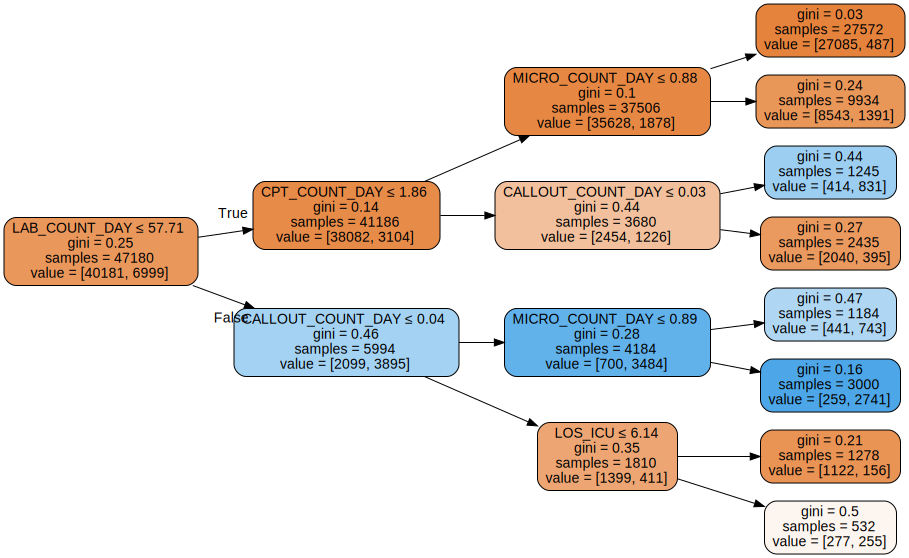

In [ ]:
# draw model
dot_data = export_graphviz(surr_model_dt, out_file=None, filled=True, rounded=True, special_characters=True, feature_names=features_list, rotate=True, precision=2)
graphviz.Source(dot_data)

How well can the surrogate model represent the full model? Not super well, but that's the price we pay for this method. 


In [ ]:
# to calculate accuracy:
accuracy_score(y_pred_rf, y_pred_dt)

0.9194997880457821

In [ ]:
# to calculate F1 score:
f1_score(y_pred_rf, y_pred_dt)

0.6943997425168973

In [ ]:
# to display multiple classification-related metrics:
print(classification_report(y_pred_rf, y_pred_dt, digits = 3))

              precision    recall  f1-score   support

           0      0.936     0.972     0.954     40181
           1      0.795     0.617     0.694      6999

    accuracy                          0.919     47180
   macro avg      0.865     0.794     0.824     47180
weighted avg      0.915     0.919     0.915     47180



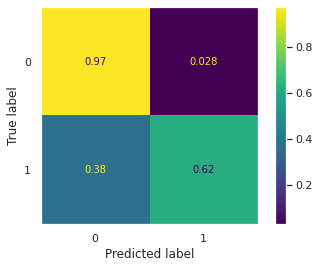

In [ ]:
# recall-related metrics (% of row)
ConfusionMatrixDisplay.from_estimator(surr_model_dt, X_train, y_pred_rf, normalize = 'true') 
plt.grid(False)

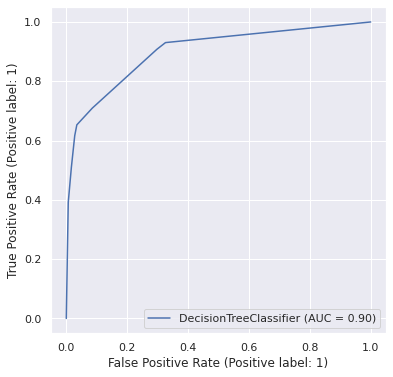

In [ ]:
# to plot an ROC:
fig, ax = plt.subplots(figsize=(6, 6)) # modify figure size
RocCurveDisplay.from_estimator(surr_model_dt, X_train, y_pred_rf, ax = ax)

---

# 6. References

* [Interpretable Machine Learning: A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/)
* [Welcome to the SHAP Documentation](https://shap-lrjball.readthedocs.io/en/latest/index.html)
* [Explain Your Model with the SHAP Values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)